# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [2]:
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
from datetime import datetime
sns.set_style("whitegrid")

In [3]:
df= pd.read_csv('dff5.csv')
df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df = df[['ds', 'y', 'fbsp','diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs']]
df 


,ds,y,fbsp,diff,tby,ffr,fta,eps,div,une,wti,ppi,rfs
0,2009-01-28,874.09,775.368737,98.721263,2.71,0.15,1927437.0,18.75,3.23,7.8,42.04,171.2,336929.0
1,2009-01-29,845.14,771.778314,73.361686,2.87,0.15,1927437.0,18.75,3.23,7.8,41.58,171.2,336929.0
2,2009-01-30,825.88,769.800284,56.079716,2.87,0.15,1927437.0,18.75,3.23,7.8,41.73,171.2,336929.0
3,2009-02-02,825.44,774.798116,50.641884,2.76,0.22,1927437.0,15.31,3.24,8.3,41.35,169.3,335576.0
4,2009-02-03,838.51,772.782361,65.727639,2.89,0.22,1927437.0,15.31,3.24,8.3,40.87,169.3,335576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2761,2020-02-21,3337.75,3176.089345,161.660655,1.46,1.58,4171570.0,135.28,1.79,3.5,53.36,196.7,525810.0
2762,2020-02-24,3225.89,3177.664932,48.225068,1.38,1.58,4171570.0,135.28,1.79,3.5,51.36,196.7,525810.0
2763,2020-02-25,3128.21,3179.642531,-51.432531,1.33,1.58,4171570.0,135.28,1.79,3.5,49.78,196.7,525810.0
2764,2020-02-26,3116.39,3181.017180,-64.627180,1.33,1.58,4158637.0,135.28,1.79,3.5,48.67,196.7,525810.0


In [4]:
dfnl = df[['ds', 'y', 'fbsp','tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs']]

In [5]:
# adding nonlinear terms
dfnl['fbsp_tby'] = dfnl['fbsp'] * dfnl['tby']
dfnl['fbsp_ffr'] = dfnl['fbsp'] * dfnl['ffr']
dfnl['fbsp_div'] = dfnl['fbsp'] * dfnl['div']
dfnl['eps_tby'] = dfnl['eps'] * dfnl['tby']
dfnl['eps_ffr'] = dfnl['eps'] * dfnl['ffr']
dfnl['eps_div'] = dfnl['eps'] * dfnl['div']
dfnl.to_csv('dfnl.csv')
dfnl

,ds,y,fbsp,tby,ffr,fta,eps,div,une,wti,ppi,rfs,fbsp_tby,fbsp_ffr,fbsp_div,eps_tby,eps_ffr,eps_div
0,2009-01-28,874.09,775.368737,2.71,0.15,1927437.0,18.75,3.23,7.8,42.04,171.2,336929.0,2101.249277,116.305311,2504.441020,50.8125,2.8125,60.5625
1,2009-01-29,845.14,771.778314,2.87,0.15,1927437.0,18.75,3.23,7.8,41.58,171.2,336929.0,2215.003762,115.766747,2492.843955,53.8125,2.8125,60.5625
2,2009-01-30,825.88,769.800284,2.87,0.15,1927437.0,18.75,3.23,7.8,41.73,171.2,336929.0,2209.326816,115.470043,2486.454919,53.8125,2.8125,60.5625
3,2009-02-02,825.44,774.798116,2.76,0.22,1927437.0,15.31,3.24,8.3,41.35,169.3,335576.0,2138.442800,170.455585,2510.345896,42.2556,3.3682,49.6044
4,2009-02-03,838.51,772.782361,2.89,0.22,1927437.0,15.31,3.24,8.3,40.87,169.3,335576.0,2233.341023,170.012119,2503.814849,44.2459,3.3682,49.6044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2761,2020-02-21,3337.75,3176.089345,1.46,1.58,4171570.0,135.28,1.79,3.5,53.36,196.7,525810.0,4637.090444,5018.221166,5685.199928,197.5088,213.7424,242.1512
2762,2020-02-24,3225.89,3177.664932,1.38,1.58,4171570.0,135.28,1.79,3.5,51.36,196.7,525810.0,4385.177607,5020.710593,5688.020229,186.6864,213.7424,242.1512
2763,2020-02-25,3128.21,3179.642531,1.33,1.58,4171570.0,135.28,1.79,3.5,49.78,196.7,525810.0,4228.924567,5023.835200,5691.560131,179.9224,213.7424,242.1512
2764,2020-02-26,3116.39,3181.017180,1.33,1.58,4158637.0,135.28,1.79,3.5,48.67,196.7,525810.0,4230.752849,5026.007144,5694.020752,179.9224,213.7424,242.1512


In [6]:
dfnlf = dfnl[['ds', 'y', 'fbsp','tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr', 'eps_div']]
dfnlf.to_csv('dfnlf.csv')
dfnlf = pd.read_csv('dfnlf.csv', parse_dates = True, index_col = 0)

In [7]:
p = 0.9
# Train around 90% of dataset 
cutoff = int((p*len(df)//100)*100)
df_train = df[:cutoff].copy()
df_test = df[cutoff:].copy()

dfnlf_train = dfnlf[:cutoff].copy()
dfnlf_test = dfnlf[cutoff:].copy()

In [8]:
#changing to datetime
dfnlf_train['ds'] = pd.to_datetime(dfnlf_train['ds'])
dfnlf_test['ds'] = pd.to_datetime(dfnlf_test['ds'])

In [9]:
df.columns

Index(['ds', 'y', 'fbsp', 'diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs'],
      dtype='object')

In [10]:
dfnlf.columns

Index(['ds', 'y', 'fbsp', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti',
       'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr',
       'eps_div'],
      dtype='object')

In [29]:
#possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'per',
#      'une', 'rus', 'wti', 'ppi', 'rfs', 'vix']

In [11]:
possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div',
       'eps_tby', 'eps_ffr', 'eps_div']

In [12]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False, normalize=True, copy_X = True)
reg.fit(dfnlf_train[possible_features], dfnlf_train['y'] - dfnlf_train.fbsp)

LinearRegression(fit_intercept=False, normalize=True)

In [25]:
coef = []
for i in range(len(possible_features)):
    coef.append(np.round(reg.coef_[i],5))

print(coef)

[113.15502, -354.26809, 0.00015, -5.28312, 123.56335, -64.34695, 2.48366, -7.61091, 0.00604, -0.04495, -0.27045, -0.44089, -0.15054, 9.89, 2.03723]


In [26]:
#consider only the linear features. Find the maximum/mean value for each feature

measure = []
for col in dfnlf.columns[3:]:
    measure.append(np.max(abs(dfnlf[col])))
print(measure)

[4.01, 2.42, 4516077.0, 143.76, 3.6, 10.0, 113.39, 208.3, 526930.0, 9326.747422044637, 7380.301139099929, 6188.196538371148, 444.7548000000001, 338.8726, 291.7222]


In [27]:
rescaled_coef = []
for i in range(len(coef)):
    rescaled_coef.append(np.round(coef[i]*measure[i],3))

print(rescaled_coef)

#possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti', 'ppi', 'rfs']

[453.752, -857.329, 677.412, -759.501, 444.828, -643.47, 281.622, -1585.353, 3182.657, -419.237, -1996.002, -2728.314, -66.953, 3351.45, 594.305]


In [28]:
pp_test = dfnlf_test.fbsp.copy() # predicted price on testing data 
pp_train = dfnlf_train.fbsp.copy() # predicted price on training data 

In [29]:
dfnlf_test1 = dfnlf_test[possible_features].copy()
dfnlf_train1 = dfnlf_train[possible_features].copy()

In [30]:
for i in range(len(possible_features)):
    pp_test += coef[i] * dfnlf_test1[dfnlf_test1.columns[i]].ravel()
    pp_train += coef[i] * dfnlf_train1[dfnlf_train1.columns[i]].ravel()


In [31]:
from sklearn.metrics import mean_squared_error as MSE
# MSE for test data
# Actual close price: df_test[:test_time].y 
# Predicted price by prophet: pred_test
# Predicted price by tuning 
mse1 = MSE(dfnlf_test.y, dfnlf_test.fbsp) #
mse2 = MSE(dfnlf_test.y, pp_test)
print(mse1,mse2)

30385.834822789413 29291.716895594094


In [32]:
# MSE for train data
mse3 = MSE(dfnlf_train.y, dfnlf_train.fbsp)
mse4 = MSE(dfnlf_train.y, pp_train)
print(mse3,mse4)

18536.638305640623 2467.284235669177


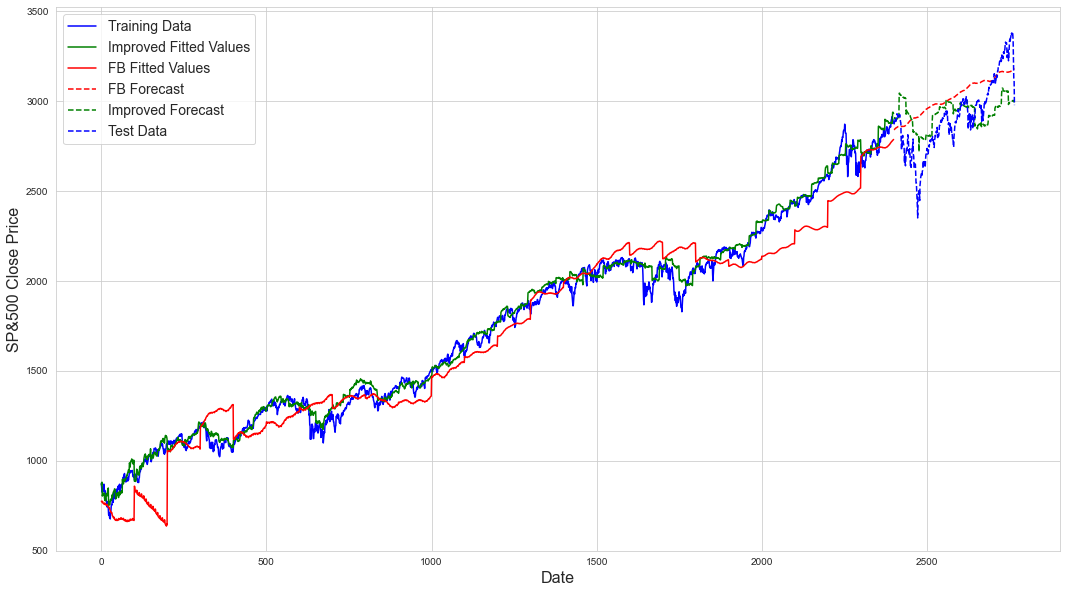

In [33]:
#plot with labels as x-axis

plt.figure(figsize=(18,10))

# plot the training data
plt.plot(dfnlf_train.y,'b',
            label = "Training Data")

plt.plot(pp_train,'g-',
            label = "Improved Fitted Values")

# plot the fit
plt.plot(dfnlf_train.fbsp,'r-',
            label = "FB Fitted Values")

# # plot the forecast
plt.plot(dfnlf_test.fbsp,'r--',
            label = "FB Forecast")
plt.plot(pp_test,'g--',
            label = "Improved Forecast")
plt.plot(dfnlf_test.y,'b--',
            label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()

In [ ]:
#plot with year as x-axis

plt.figure(figsize=(18,10))

# plot the training data
plt.plot(dfnlf_train.ds,dfnlf_train.y,'b',
            label = "Training Data")

plt.plot(dfnlf_train.ds, pp_train,'g-',
            label = "Improved Fitted Values")

# plot the fit
plt.plot(dfnlf_train.ds, dfnlf_train.fbsp,'r-',
            label = "FB Fitted Values")

# # plot the forecast
plt.plot(dfnlf_test.ds, dfnlf_test.fbsp,'r--',
            label = "FB Forecast")
plt.plot(dfnlf_test.ds, pp_test,'g--',
            label = "Improved Forecast")
plt.plot(dfnlf_test.ds,dfnlf_test.y,'b--',
            label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()